In [7]:

import os
import pickle
import pandas as pd
# from postProcessingFunctions import processOutputs, replaceValueInFile, parallelizeFunction, genExtList
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import gumbel_r, gumbel_l
from scipy.stats import genextreme

import re

import numpy as np

from IPython.display import display, Markdown

import moorpy as mp
import copy

from moorpy_functions import genMoorpySys2


In [8]:
resultsFol = r'..\results'
dataFol = r'..\data'

In [9]:

fatBinDf = pd.read_excel(os.path.join(dataFol, r"envCond.xlsx"), sheet_name='9.6D_deficit', skiprows=[1])
# df['bin'] = df['index'].str.extract(r'_.*_(\d+)_.').astype(int)
# df = df.sort_values(by='bin')
# df = df.merge(fatBinDf, on='bin', how='left')


#checked the impact of reducing the chain size directly - without actually adjusting the chain properties
lineDamageDict  = {     
                      'C135_0'   : os.path.join(resultsFol, r"P200_C135_L1430_clump40_fat_0_damage.parquet"),
                      'C135_10'  : os.path.join(resultsFol, r"P200_C135_L1430_clump40_fat_10_damage.parquet"),
                      'C135_-50' : os.path.join(resultsFol, r"P200_C135_L1430_clump40_fat_-50_damage.parquet"),
                      
                }


## Compare mean tensions from dynamic simulations and value used for stiffness calculation

In [10]:
tenCompDict = {}

for key, filePath in lineDamageDict.items():

    try :

        sumDf_fat = pd.read_parquet(filePath.replace('_damage.parquet', '.parquet'))
        valHeader = valHeader = [col[0] for col in sumDf_fat.columns if col[1] == 'mean' and ('FAIR' in col[0] or 'ANCH' in col[0]) and ('HORZ' not in col[0])]
        valType   = 'mean'
        meanPd    = sumDf_fat.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy()


        moorpyTenPd = pd.read_parquet(filePath.replace('_damage.parquet', '_meanLineTensions.parquet'))
        moorpyTenPd.index = moorpyTenPd.index + '.outb'
        moorpyTenPd = moorpyTenPd.loc[meanPd.index, :]
        # moorpyTenPd.index = moorpyTenPd.index.str.replace('Run_P200','Run_P200')

        diff = (meanPd  - moorpyTenPd)/moorpyTenPd*100

        tenCompDict[key] = {'maxDiff': diff.abs().max().max(), 'maxDiffLoc': diff.abs().idxmax().max()}

    except :
        print(f'Probably file does not exist for {key}. Skipping')

display(pd.DataFrame(tenCompDict).T)  


,maxDiff,maxDiffLoc
C135_0,0.134475,Run_P200_C135_L1430_clump40_94_S1.outb
C135_10,0.148878,Run_P200_C135_L1430_clump40_95_S1.outb
C135_-50,0.087473,Run_P200_C135_L1430_clump40_98_S1.outb


## Damage calculation

In [11]:
damCaseDict = {}

for key, df_path in lineDamageDict.items():

    df = pd.read_parquet(df_path)

    df = df.reset_index()
    df['bin'] = df['index'].str.extract(r'_.*_(\d+)_.').astype(int)
    df = df.sort_values(by='bin')
    df = df.merge(fatBinDf, on='bin', how='left')

    damDict = {}
    for col in df.columns:
        if 'ANCH' in col or 'FAIR' in col:
            damDict[col] = np.sum(df[col] * df["prob"])
    
    damCaseDict[key] = damDict 

damCases = pd.DataFrame(damCaseDict)
# damCases = damCases.sort_index()

styled_df = damCases.style.background_gradient(cmap='jet', axis=0)
styled_df


,C135_0,C135_10,C135_-50
FAIRTEN1,0.250369,0.285135,0.159933
FAIRTEN6,0.221947,0.256478,0.132207
FAIRTEN7,0.209614,0.179596,0.283041
FAIRTEN12,0.174087,0.147939,0.248693
FAIRTEN13,0.161168,0.146804,0.151878
FAIRTEN18,0.136265,0.124711,0.130779
ANCHTEN1,0.244551,0.278422,0.154846
ANCHTEN6,0.229182,0.264065,0.137395
ANCHTEN7,0.204004,0.174516,0.277490
ANCHTEN12,0.183472,0.156562,0.257071


Text(10.9, 0.335, '0.33')

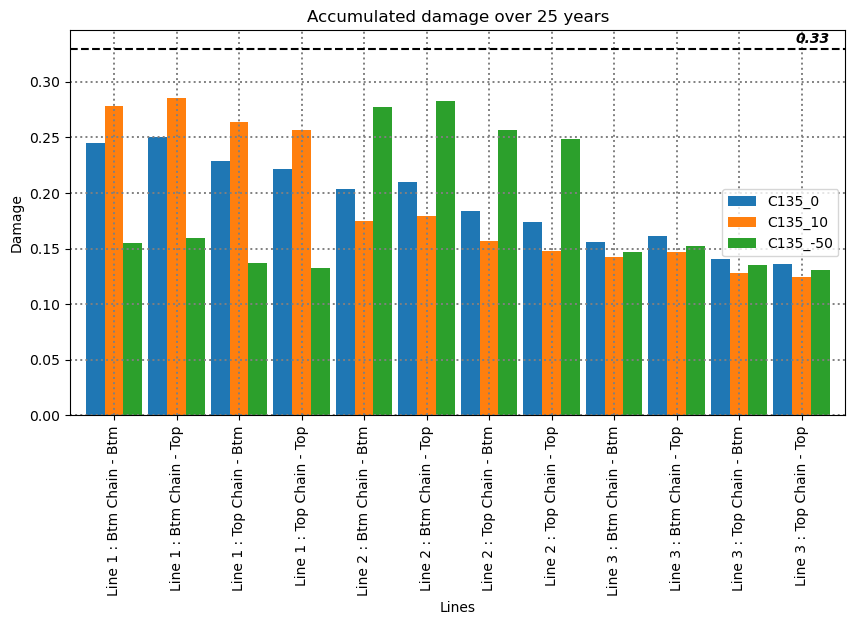

In [12]:


LineMap = { 'ANCHTEN1' : 'Line 1 : Btm Chain - Btm',
  'FAIRTEN1' : 'Line 1 : Btm Chain - Top',
  'ANCHTEN6' : 'Line 1 : Top Chain - Btm',
  'FAIRTEN6' : 'Line 1 : Top Chain - Top',

  'ANCHTEN7' : 'Line 2 : Btm Chain - Btm',
  'FAIRTEN7' : 'Line 2 : Btm Chain - Top',
  'ANCHTEN12' : 'Line 2 : Top Chain - Btm',
  'FAIRTEN12' : 'Line 2 : Top Chain - Top',

  'ANCHTEN13' : 'Line 3 : Btm Chain - Btm',
  'FAIRTEN13' : 'Line 3 : Btm Chain - Top',
  'ANCHTEN18' : 'Line 3 : Top Chain - Btm',
  'FAIRTEN18' : 'Line 3 : Top Chain - Top',
}
damRenameDf = damCases.copy()

damRenameDf = damRenameDf.loc[LineMap.keys(), :]
damRenameDf = damRenameDf.rename(index = LineMap)

damRenameDf.plot(kind='bar', figsize=(10, 5), width = 0.9)

plt.title(f'Accumulated damage over 25 years')
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
# plt.legend().remove()
plt.ylabel('Damage')
plt.xlabel('Lines')

plt.axhline(y =0.33, color='k', linestyle='--')
xLims = plt.xlim() 
plt.text(xLims[1] -.8, 0.335, '0.33', fontstyle='italic', color='k', weight='bold')